# Members

* ปริญญา วงษ์มณี 1620706752
* ตรัยพร ภักดีนอก 1620707313
* ปณิธาน คานพรหม 1620707552

#  Data Analytic Plan

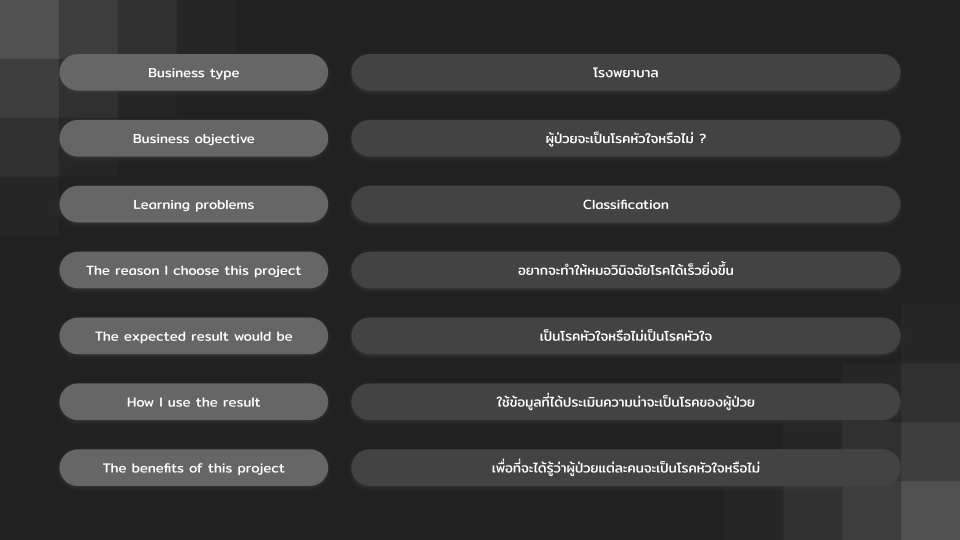

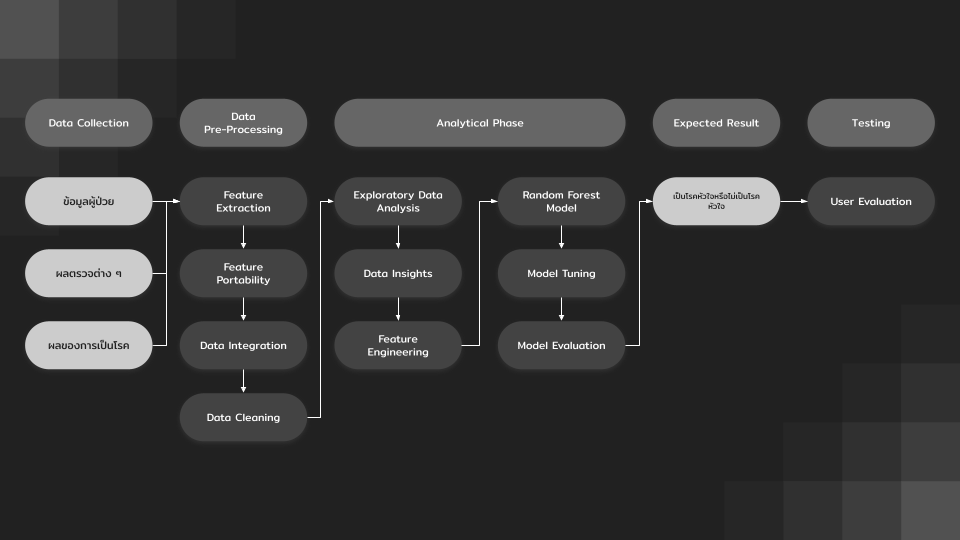

# Setup

In [209]:
import pandas as pd
import numpy as np
import altair as alt
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.inspection import permutation_importance
from yellowbrick.classifier import ConfusionMatrix

!pip install gradio -q
import gradio as gr

# Data Collection

Reference : [UCI Heart Disease Data](https://www.kaggle.com/redwankarimsony/heart-disease-data)

In [210]:
# Import data

url = "https://raw.githubusercontent.com/Parinya9625/CS434/master/heart_disease_uci.csv"
base_data = pd.read_csv(url)

In [211]:
# Show sample of data

base_data.sample(5)

,id,age,sex,dataset,cp,trestbps,chol,fbs,restecg,thalch,exang,oldpeak,slope,ca,thal,num
646,647,54,Male,Switzerland,asymptomatic,130.0,0.0,NaN,normal,110.0,True,3.0,flat,NaN,reversable defect,3
685,686,61,Male,Switzerland,asymptomatic,130.0,0.0,NaN,normal,77.0,False,2.5,flat,NaN,NaN,3
901,902,55,Male,VA Long Beach,non-anginal,NaN,NaN,False,st-t abnormality,NaN,NaN,NaN,NaN,NaN,NaN,0
617,618,47,Male,Switzerland,non-anginal,110.0,0.0,NaN,normal,120.0,True,0.0,NaN,NaN,normal,1
687,688,61,Male,Switzerland,asymptomatic,150.0,0.0,False,normal,117.0,True,2.0,flat,NaN,reversable defect,2


> อธิบายตาราง  

age : อายุ  
sex : เพศ  
dataset : ข้อมูลถูกเก็บมาจากที่ไหน  
cp : ประเภทของการเจ็บหน้าอก  
trestbps : ความดันโลหิตตอนพัก  
chol : การวัดคอเลสเตอรอล  
fbs : น้ำตาลในเลือด  
restecg : การตรวจคลื่นไฟฟ้าหัวใจ  
thalch : อัตราการเต้นหัวใจสูงสุด  
exang : อาการเจ็บหน้าอกเวลาออกกำลังกาย  
oldpeak : ST depression induced by exercise relative to rest   
slope : the slope of the peak exercise ST segment  
ca : จำนวนเส้นเลือดหลักที่เห็นจากการทำ Flourosopy (0-3)  
thal : โลหิตจางธาลัสซีเมีย  
num : 0 = ไม่เป็น, 1-4 = ระยะของโรค

# Data Pre-processing

## Data Check-up

ตรวจดูข้อมูลที่ได้นำเข้ามาใช้

In [212]:
# check how many row & column

base_data.shape

(920, 16)

In [213]:
# check null data

base_data.isna().sum()

id            0
age           0
sex           0
dataset       0
cp            0
trestbps     59
chol         30
fbs          90
restecg       2
thalch       55
exang        55
oldpeak      62
slope       309
ca          611
thal        486
num           0
dtype: int64

## Data Conversion

แปลงค่าการเป็นโรคระยะต่าง ๆ (1-4) ให้เป็นเหมือนกันทั้งหมดเพื่อให้ง่ายต่อการวิเคราะห์

In [214]:
convert_data = base_data.copy()
convert_data["num"] = convert_data["num"].apply(lambda x: 1 if x > 0 else 0)

convert_data.sample(5)

,id,age,sex,dataset,cp,trestbps,chol,fbs,restecg,thalch,exang,oldpeak,slope,ca,thal,num
649,650,55,Male,Switzerland,asymptomatic,115.0,0.0,NaN,normal,155.0,False,0.1,flat,NaN,NaN,1
710,711,67,Male,Switzerland,typical angina,145.0,0.0,False,lv hypertrophy,125.0,False,0.0,flat,NaN,normal,1
712,713,68,Male,Switzerland,asymptomatic,145.0,0.0,NaN,normal,136.0,False,1.8,upsloping,NaN,NaN,1
119,120,65,Male,Cleveland,asymptomatic,135.0,254.0,False,lv hypertrophy,127.0,False,2.8,flat,1.0,reversable defect,1
701,702,64,Female,Switzerland,asymptomatic,200.0,0.0,False,normal,140.0,True,1.0,flat,NaN,normal,1


## Data Scope

กรองข้อมูลที่จะนำมาใช้ในการวิเคราะห์ข้อมูล

In [215]:
scope_column = ["id", "age", "sex", "cp", "trestbps", "chol", "fbs", "restecg", "thalch", "exang", "num"]

scope_data = convert_data[scope_column].copy()
scope_data.sample(5)

,id,age,sex,cp,trestbps,chol,fbs,restecg,thalch,exang,num
225,226,34,Female,atypical angina,118.0,210.0,False,normal,192.0,False,0
592,593,52,Male,asymptomatic,160.0,331.0,False,normal,94.0,True,1
599,600,35,Male,asymptomatic,NaN,0.0,NaN,normal,130.0,True,1
246,247,58,Male,asymptomatic,100.0,234.0,False,normal,156.0,False,1
238,239,49,Female,atypical angina,134.0,271.0,False,normal,162.0,False,0


## Data Cleaning

จัดการข้อมูลที่มีค่าว่างและลบข้อมูลที่จะไม่ใช้งาน

In [216]:
scope_data.isna().sum()

id           0
age          0
sex          0
cp           0
trestbps    59
chol        30
fbs         90
restecg      2
thalch      55
exang       55
num          0
dtype: int64

### Drop data

ลบข้อมูลที่จะไม่ใช้งานออก

In [217]:
scope_data = scope_data.loc[scope_data["chol"] != 0]
scope_data = scope_data.loc[scope_data["restecg"].notnull()]

### Imputation

แทนค่าในช่องข้อมูลที่ว่าง

In [218]:
# Fill missing value with False
scope_data["fbs"].fillna(False, inplace = True)
scope_data["exang"].fillna(False, inplace = True)

# Fill missing value using mean
scope_data["trestbps"].fillna(round(scope_data["trestbps"].mean(), 2), inplace = True)
scope_data["chol"].fillna(round(scope_data["chol"].mean(), 2), inplace = True)
scope_data["thalch"].fillna(round(scope_data["thalch"].mean(), 2), inplace = True)

scope_data.isna().sum()

id          0
age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalch      0
exang       0
num         0
dtype: int64

## Feature Portability

จัดข้อมูลให้เป็นกลุ่ม

In [219]:
port_data = scope_data[["id"]].copy()

port_data["AgeGroup"] = pd.cut(scope_data["age"], bins=[-1, 20, 40, 60, 80, np.inf], labels=["< 20", "21 - 40", "41 - 60", "61 - 80", "> 81"])
port_data["RestingBloodGroup"] = pd.cut(scope_data["trestbps"], bins=[-1, 119, 129, 139, 180, np.inf], labels=["Normal", "Elevated", "Hypertension S1", "Hypertension S2", "Hypertensive Crisis"])
port_data["CholesterolLevel"] = pd.cut(scope_data["chol"], bins=[-1, 199, 239, np.inf], labels=["Desirable", "Borderline High", "High"])
port_data["MaximumHeartRateGroup"]  = pd.cut(scope_data["thalch"], bins=[-1, 100, 160, np.inf], labels=["Low", "Medium", "High"])

port_data.sample(5)

,id,AgeGroup,RestingBloodGroup,CholesterolLevel,MaximumHeartRateGroup
187,188,61 - 80,Hypertension S2,High,Medium
328,329,21 - 40,Elevated,Borderline High,High
541,542,41 - 60,Elevated,Desirable,Medium
165,166,41 - 60,Hypertension S1,Borderline High,High
570,571,41 - 60,Hypertension S2,Borderline High,Medium


## Merge data for EDA

รวมข้อมูลเพื่อนำไปใช้ใน EDA

In [220]:
preprocess_data = scope_data.merge(port_data)

preprocess_data.sample(5)

,id,age,sex,cp,trestbps,chol,fbs,restecg,thalch,exang,num,AgeGroup,RestingBloodGroup,CholesterolLevel,MaximumHeartRateGroup
244,245,60,Female,non-anginal,120.00,178.00,True,normal,96.0,False,0,41 - 60,Elevated,Desirable,Low
103,104,71,Female,non-anginal,110.00,265.00,True,lv hypertrophy,130.0,False,0,61 - 80,Normal,High,Medium
732,906,61,Male,non-anginal,132.71,284.00,False,normal,141.1,False,1,61 - 80,Hypertension S1,High,Medium
369,370,43,Male,atypical angina,142.00,207.00,False,normal,138.0,False,0,41 - 60,Hypertension S2,Borderline High,Medium
305,306,29,Male,atypical angina,140.00,246.77,False,normal,170.0,False,0,21 - 40,Hypertension S2,High,High


# Exploratory Data Analysis (EDA)

## Hypothesis (สมมติฐาน)

### H1 : เพศไหนมีโอกาสเป็นโรคหัวใจมากกว่ากัน

* เพื่อที่จะได้รู้ว่าเพศไหนมีโอกาสที่จะเป็นโรคหัวใจมากกว่ากัน
> ผู้ชายมีโอกาสที่จะเป็นโรคหัวใจได้มากกว่าผู้หญิง

In [221]:
preprocess_data.loc[preprocess_data["num"] == 1]["sex"].value_counts()

Male      316
Female     40
Name: sex, dtype: int64

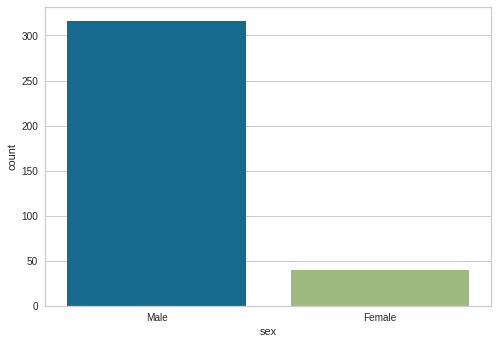

In [222]:
sns.countplot(data=preprocess_data.loc[preprocess_data["num"] == 1], x="sex")

### H2 : ช่วงอายุไหนที่มีโอกาสเป็นโรคหัวใจมากที่สุด

* เพื่อที่จะได้รู้ว่าช่วงอายุไหนมีโอกาสที่จะเป็นโรคหัวใจมากที่สุด
> ส่วนใหญ่จะเป็นโรคในช่วงอายุ 41 - 60 ปี

In [223]:
preprocess_data.loc[preprocess_data["num"] == 1]["AgeGroup"].value_counts()

41 - 60    227
61 - 80    108
21 - 40     21
> 81         0
< 20         0
Name: AgeGroup, dtype: int64

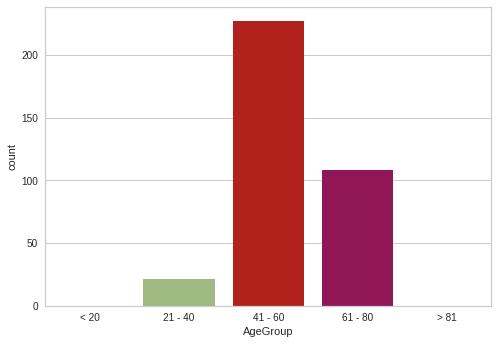

In [224]:
sns.countplot(data=preprocess_data.loc[preprocess_data["num"] == 1], x="AgeGroup")

In [225]:
preprocess_data.loc[(preprocess_data["num"] == 1) & (preprocess_data["AgeGroup"] == "41 - 60")]["age"].value_counts().head()

58    23
57    19
54    19
55    18
60    17
Name: age, dtype: int64

ยิ่งอายุมากขึ้นก็มีโอกาสที่จะเป็นโรคมาก

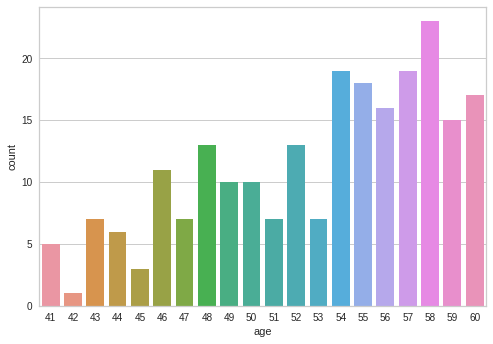

In [226]:
sns.countplot(data=preprocess_data.loc[(preprocess_data["num"] == 1) & (preprocess_data["AgeGroup"] == "41 - 60")], x="age")

### H3 : คนที่เป็นโรคหัวใจจะมีการเจ็บหน้าอกรูปแบบไหนมากที่สุด

* เพื่อที่จะได้รู้ว่าการเป็นโรคหัวใจจะมีอาการเจ็บหน้าอกมากน้อยแค่ไหน
> ส่วนใหญ่จะไม่มีอาการปรากฏให้รู้ก่อน

[ข้อมูลการเจ็บหน้าอก](https://drsant.com/2010/10/blog-post_05-4.html)

Asymptomtic : ไม่มีอาการ  
Typical angina : เจ็บหน้าอกจากหัวใจขาดเลือด  
Atypical anigina : การเจ็บแบบอื่นที่ไม่เข้าเกณฑ์ของ Typical angina  
non-anginal : ไม่ได้เกิดจากหัวใจขาดเลือด

In [227]:
preprocess_data.loc[preprocess_data["num"] == 1]["cp"].value_counts()

asymptomatic       274
non-anginal         47
atypical angina     21
typical angina      14
Name: cp, dtype: int64

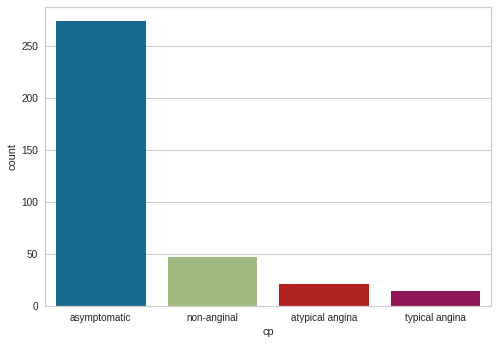

In [228]:
sns.countplot(data=preprocess_data.loc[preprocess_data["num"] == 1], x="cp")

### H4 : ช่วงความดันโลหิตของคนที่เป็นโรคหัวใจมักอยู่ที่ระดับไหน

* เพื่อที่จะได้รู้ว่าคนที่เป็นโรคนั้นจะมีความดันโลหิตขนาดไหน
> ส่วนใหญ่คนที่เป็นจะเป็นความดันโลหิตสูง ระดับที่ 2 (140 - 180 มิลลิเมตรปรอท)

Normal : ปกติ  
Elevated : ความดันโลหิตเริ่มสูง  
Hypertension S1 : ความดันโลหิตสูง ระดับที่ 1  
Hypertension S2 : ความดันโลหิตสูง ระดับที่ 2  
Hypertensive Crisis : ความดันโลหิตสูงวิกฤต

In [229]:
preprocess_data.loc[preprocess_data["num"] == 1]["RestingBloodGroup"].value_counts()

Hypertension S2        140
Hypertension S1         95
Elevated                71
Normal                  46
Hypertensive Crisis      4
Name: RestingBloodGroup, dtype: int64

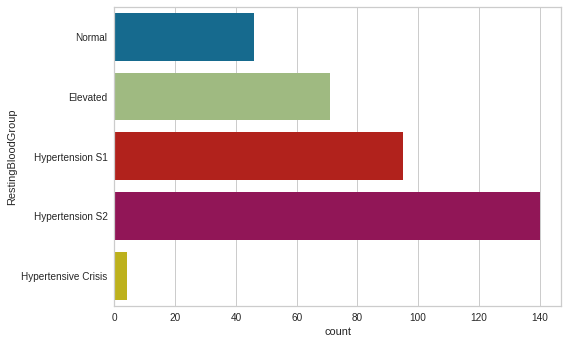

In [230]:
sns.countplot(data=preprocess_data.loc[preprocess_data["num"] == 1], y="RestingBloodGroup")

### H5 : ระดับคอเลสเตอรอลของคนที่เป็นโรคหัวใจจะอยู่ที่ช่วงไหนมากที่สุด

* เพื่อที่จะได้รู้ว่าคนที่เป็นจะมีระดับของคอเลสเตอรอลมากน้อยแค่ไหน
> ส่วนใหญ่คนที่เป็นจะมีระดับของคอเลสเตอรอลสูงมากกว่า 239 มิลลิกรัมต่อเดซิลิตร

In [231]:
preprocess_data.loc[preprocess_data["num"] == 1]["CholesterolLevel"].value_counts()

High               201
Borderline High    107
Desirable           48
Name: CholesterolLevel, dtype: int64

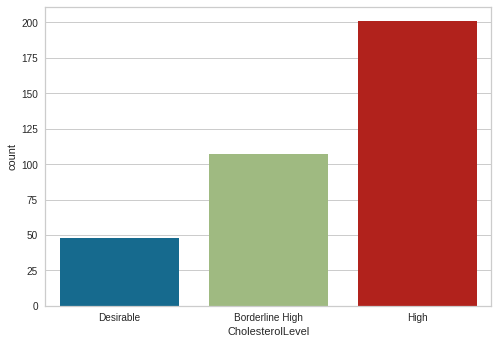

In [232]:
sns.countplot(data=preprocess_data.loc[preprocess_data["num"] == 1], x="CholesterolLevel")

# Feature Engineering

In [233]:
engineer_data = pd.DataFrame()

## Discretizing (Binning)

จัดกลุ่มข้อมูลให้อยู่ในลักษณะของถัง



In [234]:
# age bin
engineer_data["ageBin"] = pd.cut(preprocess_data["age"], bins=[-1, 20, 40, 60, 80, np.inf], labels=[1, 2, 3, 4, 5])
engineer_data["ageBin"].sample(5)

336    2
706    3
293    4
583    3
652    4
Name: ageBin, dtype: category
Categories (5, int64): [1 < 2 < 3 < 4 < 5]

In [235]:
# resting blood pressure bin
engineer_data["rbpBin"] = pd.cut(preprocess_data["trestbps"], bins=[-1, 119, 129, 139, 180, np.inf], labels=[1, 2, 3, 4, 5])
engineer_data["rbpBin"].sample(5)

27     4
650    4
603    2
647    4
659    3
Name: rbpBin, dtype: category
Categories (5, int64): [1 < 2 < 3 < 4 < 5]

In [236]:
# cholesterol bin
engineer_data["chlBin"] = pd.cut(preprocess_data["chol"], bins=[-1, 199, 239, np.inf], labels=[1, 2, 3])
engineer_data["chlBin"].sample(5)

316    1
65     3
168    3
47     3
282    2
Name: chlBin, dtype: category
Categories (3, int64): [1 < 2 < 3]

In [237]:
# maximum heart rate bin
engineer_data["mhrBin"] = pd.cut(preprocess_data["thalch"], bins=[-1, 100, 160, np.inf], labels=[1, 2, 3])
engineer_data["mhrBin"].sample(5)

330    2
192    2
601    2
41     3
375    3
Name: mhrBin, dtype: category
Categories (3, int64): [1 < 2 < 3]

In [238]:
engineer_data.sample(5)

,ageBin,rbpBin,chlBin,mhrBin
568,3,4,3,2
79,3,4,3,2
404,3,1,3,2
619,3,3,3,2
166,3,3,2,3


## Categorical Encoding

จัดข้อมูลแบบกลุ่มให้เป็นตัวเลข

### Binarization

เปลี่ยนข้อมูลให้มีค่าเป็น 1 กับ 0 โดยที่ข้อมูลหลักจะถูกกำหนดเป็นเลข 1

เป็นผู้ชายหรือไม่

In [239]:
engineer_data["isMale"] = preprocess_data["sex"].map({"Male" : 1, "Female" : 0})
engineer_data["isMale"].sample(5)

292    1
156    1
741    1
267    1
194    0
Name: isMale, dtype: int64

น้ำตาลในเลือดสูงหรือไม่

In [240]:
engineer_data["isFbs"] = preprocess_data["fbs"].apply(lambda x: 1 if x else 0)
engineer_data["isFbs"].sample(5)

263    0
170    0
437    0
713    1
443    0
Name: isFbs, dtype: int64

มีอาการเจ็บหน้าอกหรือไม่

In [241]:
engineer_data["isExa"] = preprocess_data["exang"].apply(lambda x: 1 if x else 0)
engineer_data["isExa"].sample(5)

176    0
290    0
533    1
177    1
95     1
Name: isExa, dtype: int64

In [242]:
engineer_data.sample(5)

,ageBin,rbpBin,chlBin,mhrBin,isMale,isFbs,isExa
198,3,2,3,3,0,0,0
267,3,2,2,2,1,1,0
569,3,4,3,2,1,0,1
197,3,3,2,2,0,0,1
537,3,4,1,2,1,0,1


### One-hot Encoding

กระจายข้อมูลแบบกลุ่มที่ไม่สามารถใช้ Binarization ในการทำออกให้เป็น Column ใหม่ เพื่อที่จะได้ทำ Binarization ได้ โดยที่ข้อมูลหลักจะถูกกำหนดให้เป็นเลข 1

In [243]:
# Chest pain type
for cpt in preprocess_data["cp"].unique().tolist() :
  engineer_data["cpt_" + cpt.replace("-", " ").title().replace(" ", "")] = preprocess_data["cp"].apply(lambda x: 1 if x == cpt else 0)
engineer_data.sample(5)

,ageBin,rbpBin,chlBin,mhrBin,isMale,isFbs,isExa,cpt_TypicalAngina,cpt_Asymptomatic,cpt_NonAnginal,cpt_AtypicalAngina
222,2,1,1,3,0,0,0,0,0,1,0
63,3,3,3,3,0,1,0,0,0,1,0
327,2,3,1,2,1,0,0,0,0,1,0
492,2,1,3,2,0,0,1,0,1,0,0
184,3,4,3,3,0,0,0,0,1,0,0


In [244]:
# Resting electrocardiographic (การตรวจคลื่นไฟฟ้าหัวใจ)
for ecg in preprocess_data["restecg"].unique().tolist() :
  engineer_data["ecg_" + ecg.replace("-", " ").title().replace(" ", "")] = preprocess_data["restecg"].apply(lambda x: 1 if x == ecg else 0)
engineer_data.sample(5)

,ageBin,rbpBin,chlBin,mhrBin,isMale,isFbs,isExa,cpt_TypicalAngina,cpt_Asymptomatic,cpt_NonAnginal,cpt_AtypicalAngina,ecg_LvHypertrophy,ecg_Normal,ecg_StTAbnormality
400,3,1,3,1,1,0,0,0,0,0,1,0,1,0
250,3,1,2,2,1,0,1,0,1,0,0,0,1,0
179,3,3,3,3,1,1,0,0,0,1,0,1,0,0
662,4,3,2,2,1,0,0,0,1,0,0,0,1,0
427,3,4,3,2,0,0,0,0,0,0,1,0,1,0


In [245]:
engineer_data["num"] = preprocess_data["num"]
engineer_data.sample(5)

,ageBin,rbpBin,chlBin,mhrBin,isMale,isFbs,isExa,cpt_TypicalAngina,cpt_Asymptomatic,cpt_NonAnginal,cpt_AtypicalAngina,ecg_LvHypertrophy,ecg_Normal,ecg_StTAbnormality,num
242,3,3,3,3,0,0,0,0,1,0,0,0,1,0,0
501,3,1,3,3,1,0,0,0,1,0,0,0,1,0,1
446,3,3,3,2,0,0,0,0,0,0,1,0,0,1,0
423,3,2,1,2,1,0,0,0,0,0,1,0,1,0,0
668,4,4,3,2,1,1,1,0,1,0,0,0,0,1,1


# Pipeline

นำวิธีการที่ใช้ในการทำ Feature Engineering มาทำเป็น Pipeline เพื่อที่จะได้สามารถนำไปใช้งานได้ง่าย

In [246]:
class Pipeline() :
  def __init__(self) :
    self.cpt = ["asymptomatic", "non-anginal", "atypical angina", "typical angina"]
    self.ecg = ["normal", "lv hypertrophy", "st-t abnormality"]

  def binning(self, data) :
    # age
    data["ageBin"] = pd.cut(data["age"], bins=[-1, 20, 40, 60, 80, np.inf], labels=[1, 2, 3, 4, 5])
    # resting blood pressure
    data["rbpBin"] = pd.cut(data["trestbps"], bins=[-1, 119, 129, 139, 180, np.inf], labels=[1, 2, 3, 4, 5])
    # cholesterol
    data["chlBin"] = pd.cut(data["chol"], bins=[-1, 199, 239, np.inf], labels=[1, 2, 3])
    # maximum heart rate
    data["mhrBin"] = pd.cut(data["thalch"], bins=[-1, 100, 160, np.inf], labels=[1, 2, 3])
    return data
  
  def encoding(self, data) :
    # Binarization
    data["isMale"] = data["sex"].map({"Male" : 1, "Female" : 0})
    data["isFbs"] = data["fbs"].apply(lambda x: 1 if x else 0)
    data["isExa"] = data["exang"].apply(lambda x: 1 if x else 0)
    # One-hot encoding
    for cpt in self.cpt :
      data["cpt_" + cpt.replace("-", " ").title().replace(" ", "")] = data["cp"].apply(lambda x: 1 if x == cpt else 0)
    for ecg in self.ecg :
      data["ecg_" + ecg.replace("-", " ").title().replace(" ", "")] = data["restecg"].apply(lambda x: 1 if x == ecg else 0)
    return data

  def transform(self, data) :
    base_data = data.copy()
    data = self.binning(data)
    data = self.encoding(data)
    return data.drop(base_data.columns, axis=1, errors="ignore")

pipeline = Pipeline()

# Splitting

แบ่งข้อมูลเพื่อที่จะนำไปใช้ Train และทดสอบกับโมเดล โดยข้อมูลที่จะใช้ทดสอบจะถูกแบ่งออก 30%

In [247]:
# Hold-out : Stratify
key = "num"
xRaw, xTest, yRaw, yTest = train_test_split(engineer_data.drop(key, axis=1), engineer_data[key], random_state=6752, stratify=engineer_data[key], test_size=0.3)
xTrain, xVal, yTrain, yVal = train_test_split(xRaw, yRaw, random_state=6752, stratify=yRaw, test_size=0.3)

In [248]:
print(f"Test Data : {xTest.shape}\nTrain Data : {xTrain.shape}\nValidate Data : {xVal.shape}")

Test Data : (225, 14)
Train Data : (365, 14)
Validate Data : (157, 14)


# Modeling

## Benchmark

ทดสอบหาโมเดลที่มีความแม่นยำสูง

              precision    recall  f1-score   support

           0       0.52      1.00      0.69        82
           1       0.00      0.00      0.00        75

    accuracy                           0.52       157
   macro avg       0.26      0.50      0.34       157
weighted avg       0.27      0.52      0.36       157



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


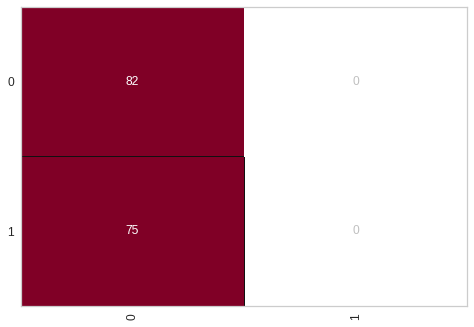

In [249]:
model = DummyClassifier(strategy="most_frequent", random_state=6752)
cm = ConfusionMatrix(model)
cm.fit(xTrain, yTrain)
cm.score(xVal, yVal)
print(classification_report(yVal, model.predict(xVal)))

              precision    recall  f1-score   support

           0       0.51      0.43      0.47        82
           1       0.47      0.56      0.51        75

    accuracy                           0.49       157
   macro avg       0.49      0.49      0.49       157
weighted avg       0.49      0.49      0.49       157



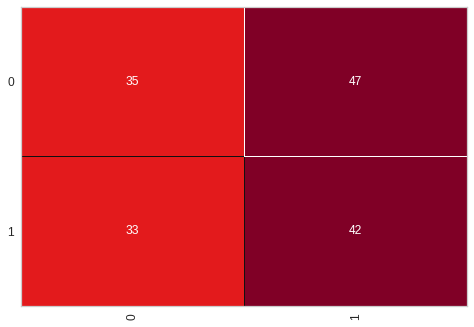

In [250]:
model = DummyClassifier(strategy="uniform", random_state=6752)
cm = ConfusionMatrix(model)
cm.fit(xTrain, yTrain)
cm.score(xVal, yVal)
print(classification_report(yVal, model.predict(xVal)))

              precision    recall  f1-score   support

           0       0.72      0.77      0.75        82
           1       0.73      0.68      0.70        75

    accuracy                           0.73       157
   macro avg       0.73      0.72      0.72       157
weighted avg       0.73      0.73      0.73       157



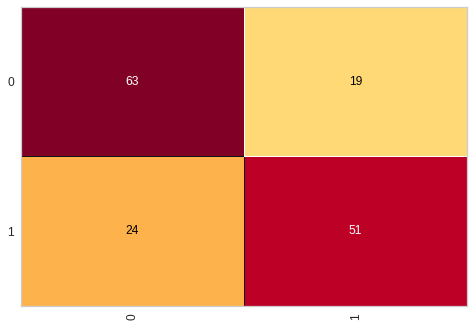

In [251]:
model = RandomForestClassifier(random_state=6752)
cm = ConfusionMatrix(model)
cm.fit(xTrain, yTrain)
cm.score(xVal, yVal)
print(classification_report(yVal, model.predict(xVal)))

              precision    recall  f1-score   support

           0       0.71      0.74      0.73        82
           1       0.70      0.67      0.68        75

    accuracy                           0.71       157
   macro avg       0.71      0.71      0.71       157
weighted avg       0.71      0.71      0.71       157



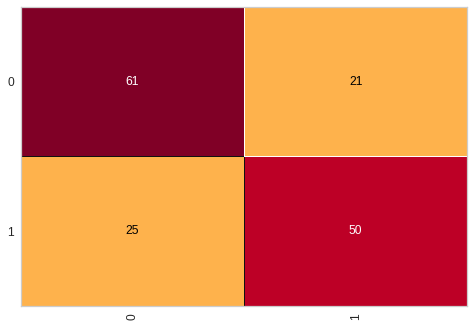

In [252]:
model = DecisionTreeClassifier(random_state=6752)
cm = ConfusionMatrix(model)
cm.fit(xTrain, yTrain)
cm.score(xVal, yVal)
print(classification_report(yVal, model.predict(xVal)))

**RandomForestClassifier เป็นโมเดลที่มีประสิทธิภาพสูงที่สุด**

## Tuning

ปรับโมเดลให้มีประสิทธิภาพดีที่สุด

n_estimators : number of threes in the forest  
max_depth : maximum depth of the tree  
max_features : number of features to consider when looking for the best split  

In [253]:
model = RandomForestClassifier(random_state=6752, n_jobs=-1)

paramGrid = [{"n_estimators": [50, 100, 150], "max_depth" : [20, 40, None], "max_features" : [10, "auto", "log2"]}]

gridSearch = GridSearchCV(model, paramGrid, cv=10, scoring="f1")
gridSearch.fit(xTrain, yTrain)

GridSearchCV(cv=10,
             estimator=RandomForestClassifier(n_jobs=-1, random_state=6752),
             param_grid=[{'max_depth': [20, 40, None],
                          'max_features': [10, 'auto', 'log2'],
                          'n_estimators': [50, 100, 150]}],
             scoring='f1')

In [254]:
gridSearch.best_estimator_

RandomForestClassifier(max_depth=20, n_jobs=-1, random_state=6752)

In [255]:
print(classification_report(yVal, gridSearch.best_estimator_.predict(xVal)))

              precision    recall  f1-score   support

           0       0.72      0.77      0.75        82
           1       0.73      0.68      0.70        75

    accuracy                           0.73       157
   macro avg       0.73      0.72      0.72       157
weighted avg       0.73      0.73      0.73       157



## Evaluation

ประเมินผลการทำโมเดล

In [256]:
print(classification_report(yTest, gridSearch.best_estimator_.predict(xTest)))

              precision    recall  f1-score   support

           0       0.80      0.83      0.82       118
           1       0.81      0.78      0.79       107

    accuracy                           0.80       225
   macro avg       0.80      0.80      0.80       225
weighted avg       0.80      0.80      0.80       225



สร้างตัวอย่างข้อมูลให้โมเดลลองคาดเดา

In [257]:
# Sample Data 1
evaluation_data = pd.DataFrame({"age": 43, "sex": "Female", "cp": "asymptomatic", "trestbps": 122, "chol": 140, "fbs": False, "restecg": "normal", "thalch": 165, "exang": False}, index=[0])
evaluation_transform = pipeline.transform(evaluation_data)
evaluation_transform

,ageBin,rbpBin,chlBin,mhrBin,isMale,isFbs,isExa,cpt_Asymptomatic,cpt_NonAnginal,cpt_AtypicalAngina,cpt_TypicalAngina,ecg_Normal,ecg_LvHypertrophy,ecg_StTAbnormality
0,3,2,1,3,0,0,0,1,0,0,0,1,0,0


In [258]:
result = gridSearch.best_estimator_.predict_proba(evaluation_transform)[0]
print(f"No Heart Disease {result[0]}, Have Heart Disease {result[1]}\n")

No Heart Disease 0.8166666666666668, Have Heart Disease 0.18333333333333335



/usr/local/lib/python3.7/dist-packages/sklearn/base.py:488: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names must be in the same order as they were in fit.

  warnings.warn(message, FutureWarning)


In [259]:
# Sample Data 2
evaluation_data = pd.DataFrame({"age": 57, "sex": "Male", "cp": "non-anginal", "trestbps": 122, "chol": 264, "fbs": False, "restecg": "lv hypertrophy", "thalch": 100, "exang": False}, index=[0])
evaluation_transform = pipeline.transform(evaluation_data)
evaluation_transform

,ageBin,rbpBin,chlBin,mhrBin,isMale,isFbs,isExa,cpt_Asymptomatic,cpt_NonAnginal,cpt_AtypicalAngina,cpt_TypicalAngina,ecg_Normal,ecg_LvHypertrophy,ecg_StTAbnormality
0,3,2,3,1,1,0,0,0,1,0,0,0,1,0


In [260]:
result = gridSearch.best_estimator_.predict_proba(evaluation_transform)[0]
print(f"No Heart Disease {result[0]}, Have Heart Disease {result[1]}\n")

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:488: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names must be in the same order as they were in fit.

  warnings.warn(message, FutureWarning)


No Heart Disease 0.43857142857142845, Have Heart Disease 0.5614285714285715



## Permutation Feature Importance

หา Features ที่มีผลต่อโมเดลในการทำนายมากที่สุด

In [261]:
pif_scoring = ["r2", "neg_mean_squared_error"]
pif_multi = permutation_importance(gridSearch.best_estimator_, xVal, yVal, n_repeats=50, random_state=6752, scoring=pif_scoring)

                   r2                   
 ---------------------------------------
cpt_Asymptomatic     |    0.312 ± 0.082
isExa                |    0.312 ± 0.067
isMale               |    0.126 ± 0.057
ageBin               |    0.122 ± 0.069
chlBin               |    0.100 ± 0.053
ecg_StTAbnormality   |    0.065 ± 0.045
ecg_Normal           |    0.056 ± 0.037
ecg_LvHypertrophy    |    0.044 ± 0.036
cpt_TypicalAngina    |    0.018 ± 0.011
isFbs                |    0.016 ± 0.044
mhrBin               |    0.014 ± 0.064
rbpBin               |   -0.005 ± 0.077
cpt_NonAnginal       |   -0.022 ± 0.044
cpt_AtypicalAngina   |   -0.066 ± 0.041


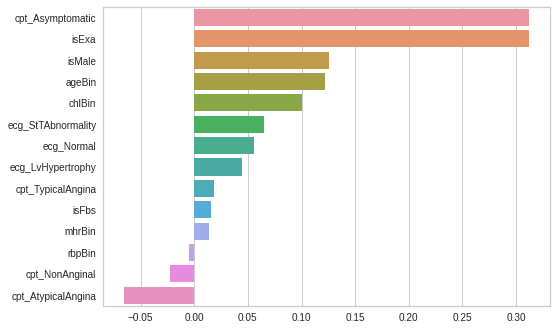

In [262]:
print(str.center(pif_scoring[0], 39), "\n", "-" * 39)
pif_model = pif_multi[pif_scoring[0]]
for i in pif_model.importances_mean.argsort()[::-1] :
  print(f"{xVal.columns[i]:20} | {pif_model.importances_mean[i]:>8.3f} ± {pif_model.importances_std[i]:.3f}")

arg_sort = pif_model.importances_mean.argsort()[::-1]
sns.barplot(x=pif_model.importances_mean[arg_sort], y=xVal.columns[arg_sort])

         neg_mean_squared_error         
 ---------------------------------------
cpt_Asymptomatic     |    0.078 ± 0.021
isExa                |    0.078 ± 0.017
isMale               |    0.031 ± 0.014
ageBin               |    0.030 ± 0.017
chlBin               |    0.025 ± 0.013
ecg_StTAbnormality   |    0.016 ± 0.011
ecg_Normal           |    0.014 ± 0.009
ecg_LvHypertrophy    |    0.011 ± 0.009
cpt_TypicalAngina    |    0.005 ± 0.003
isFbs                |    0.004 ± 0.011
mhrBin               |    0.003 ± 0.016
rbpBin               |   -0.001 ± 0.019
cpt_NonAnginal       |   -0.006 ± 0.011
cpt_AtypicalAngina   |   -0.016 ± 0.010


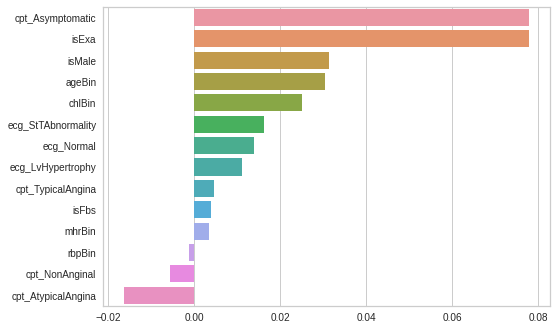

In [263]:
print(str.center(pif_scoring[1], 39), "\n", "-" * 39)
pif_model = pif_multi[pif_scoring[1]]
for i in pif_model.importances_mean.argsort()[::-1] :
  print(f"{xVal.columns[i]:20} | {pif_model.importances_mean[i]:>8.3f} ± {pif_model.importances_std[i]:.3f}")

arg_sort = pif_model.importances_mean.argsort()[::-1]
sns.barplot(x=pif_model.importances_mean[arg_sort], y=xVal.columns[arg_sort])

# Deployment

In [264]:
def prediction(age, sex, cp, rbp, chl, fbs, ecg, mhr, exa) :
  data = pd.DataFrame({"age": age, "sex": sex, "cp": cp, "trestbps": rbp, "chol": chl, "fbs": fbs, "restecg": ecg, "thalch": mhr, "exang": exa}, index=[0])
  result = gridSearch.best_estimator_.predict_proba(pipeline.transform(data))[0]
  return {"No Heart Disease": result[0], "Have Heart Disease": result[1]}


ip_age = gr.inputs.Slider(0, 100, 1, 21, "Age")
ip_sex = gr.inputs.Dropdown(["Male", "Female"], default="Male", label="Gender")
ip_cp = gr.inputs.Dropdown(pipeline.cpt, default=pipeline.cpt[0], label="Chest Pain Type")
ip_rbp = gr.inputs.Slider(0, 500, 1, 100, "Resting Blood Pressure")
ip_chl = gr.inputs.Slider(0, 500, 1, 100, "Cholesterol")
ip_fbs = gr.inputs.Checkbox(False, "Fasting Blood Sugar")
ip_ecg = gr.inputs.Dropdown(pipeline.ecg, default=pipeline.ecg[0], label="Electrocardiogram Observation")
ip_mhr = gr.inputs.Slider(0, 400, 1, 120, "Maximum Heart Rate")
ip_exa = gr.inputs.Checkbox(False, "Exercise Induced Angina")

gr.Interface(prediction, [ip_age, ip_sex, ip_cp, ip_rbp, ip_chl, ip_fbs, ip_ecg, ip_mhr, ip_exa], "label").launch()

Colab notebook detected. To show errors in colab notebook, set `debug=True` in `launch()`
Running on public URL: https://32187.gradio.app

This share link will expire in 72 hours. To get longer links, send an email to: support@gradio.app


(<Flask 'gradio.networking'>,
 'http://127.0.0.1:7862/',
 'https://32187.gradio.app')

# References

* [UCI Heart Disease Data](https://www.kaggle.com/redwankarimsony/heart-disease-data)
* [ข้อมูลการเจ็บหน้าอก](https://drsant.com/2010/10/blog-post_05-4.html)
* [Model Tuning with GridSearchCV](https://towardsdatascience.com/gridsearchcv-for-beginners-db48a90114ee)
* [Permutation feature importance](https://scikit-learn.org/stable/modules/permutation_importance.html)